In [42]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
def preprocessing(words):
    unwanted_chars = ['ß', 'à', 'ä', 'ç', 'è', 'é', 'ï', 'ñ', 'ó', 'ö', 'ü', 'ā']

    def contains_unwanted_chars(word):
        return any(char in unwanted_chars for char in word)

    words = [haiku for haiku in words if not any(contains_unwanted_chars(word) for word in haiku)]
    return words

def load_data(path):
    with open(path, 'r') as f:
        words = f.read().splitlines()
    words = preprocessing(words)
    return words

words = load_data('lines.txt')
words = [wr.replace("/", "").replace("$", "") for wr in words]
chars = sorted(list(set(''.join(words)))) #+ ["<S>", "<M>", "<E>"]
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}

In [44]:
def build_dataset(words):
    # make block size max length of a word
    block_size = 10
    X, Y = [], []
    for w in words:
        context = [3] * block_size
        #print(w)
        # w = w.split("  ")
        # chs = ["<S>"] + list(w[0]) + ["<M>"] + list(w[1])+ ["<M>"] + list(w[2]) + ["<E>"]
        for ch in w + ".": #chs:
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(f"'{''.join(itos[i] for i in context)}'", '---->', itos[ix])

            context = context[1:] + [ix]
    
    X, Y = torch.tensor(X), torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random
random.seed(43)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtrain, Ytrain = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([637487, 10]) torch.Size([637487])
torch.Size([79514, 10]) torch.Size([79514])
torch.Size([79753, 10]) torch.Size([79753])


In [45]:
g = torch.Generator().manual_seed(213139812739)

In [46]:
from typing import List
import numpy as np

class Layer():
    def __init__(self, fan_in, fan_out, kaiming=False, activation=F.tanh):
        self.W = torch.randn((fan_in, fan_out), generator=g) * 5/3 / (fan_in ** 0.5)  if kaiming else torch.randn((fan_in, fan_out), generator=g)
        self.b = torch.randn(fan_out, generator=g) * 0

        self.params = [self.W, self.b]
        self.activation_fn = activation

        for param in self.params:
            param.requires_grad = True
    
    def activation(self, x):
        return self.activation_fn(x)
        
    def _f(self, x):
        out = x @ self.W + self.b
        return self.activation(out) if self.activation_fn else out
    
class BatchNorm():
    def __init__(self, fan_in, eps):
        self.bngain = torch.ones((1, fan_in))
        self.bnbias = torch.zeros((1, fan_in))

        self.bnmean_running = torch.zeros((1, fan_in))
        self.bnstd_running = torch.ones((1, fan_in))

        self.params = [self.bngain, self.bnbias]

        self.eps = eps

        for param in self.params:
            param.requires_grad = True

    def _f(self, x, train=True):
        mean = x.mean(0, keepdim=True)
        std = x.std(0, keepdim=True)

        if train:
            x = (x - mean) / (std + self.eps)
            x = x * self.bngain + self.bnbias
            with torch.no_grad():
                self.bnmean_running = 0.999 * self.bnmean_running + 0.001 * mean
                self.bnstd_running = 0.999 * self.bnstd_running + 0.001 * std
        else:
            x = (x - self.bnmean_running) / (self.bnstd_running + self.eps)
            x = x * self.bngain + self.bnbias

        return x

class Sequential():
    def __init__(self, layers: List[Layer]):
        self.layers = layers
        self.params = []
        for layer in self.layers:
            self.params.extend(layer.params)
    
    def forward(self, x, y, lr):
        out = x
        for layer in self.layers:
            out = layer._f(out)
        
        loss = F.cross_entropy(out, y)

        for p in self.params:
            p.grad = None
        
        loss.backward()

        for p in self.params:
            p.data += -lr * p.grad

        return loss

    def predict(self, x):
        with torch.no_grad():
            out = x
            for layer in self.layers:
                if isinstance(layer, BatchNorm):
                    out = layer._f(out, train=False)
                else:
                    out = layer._f(out)
        return out
    
    def display_layer_sizes(self):
        print("Layer Sizes (Top to Bottom):")
        for idx, layer in enumerate(self.layers):
            if isinstance(layer, Layer):
                print(f"Layer {idx + 1}: Input Size = {layer.W.shape[0]}, Output Size = {layer.W.shape[1]}")
            elif isinstance(layer, BatchNorm):
                print(f"Layer {idx + 1}: BatchNorm with Input Size = {layer.bngain.shape[1]}")
            else:
                print(f"Layer {idx + 1}: Unknown Layer Type")

In [50]:
n_embd = 30
block_size = 10
neurons = [300, 200, 100]
embeddings = torch.randn(len(chars), n_embd, generator=g)

layers = [
    Layer(n_embd * block_size, neurons[0], kaiming=True, activation=F.tanh), 
    BatchNorm(neurons[0], 1e-5),
    Layer(neurons[0], neurons[1], kaiming=True, activation=F.tanh), 
    BatchNorm(neurons[1], 1e-5),
    Layer(neurons[1], neurons[2], kaiming=True, activation=F.tanh), 
    BatchNorm(neurons[2], 1e-5),
    Layer(neurons[2], len(chars), activation=None)
]

model = Sequential(layers)

In [51]:
model.display_layer_sizes()

Layer Sizes (Top to Bottom):
Layer 1: Input Size = 300, Output Size = 300
Layer 2: BatchNorm with Input Size = 300
Layer 3: Input Size = 300, Output Size = 200
Layer 4: BatchNorm with Input Size = 200
Layer 5: Input Size = 200, Output Size = 100
Layer 6: BatchNorm with Input Size = 100
Layer 7: Input Size = 100, Output Size = 30


In [52]:
# print total parameters
total_params = sum(p.numel() for p in model.params)
print(f"Total Parameters: {total_params}")

Total Parameters: 174830


In [53]:
def train_model(
    model: Sequential, 
    num_epochs: int, 
    lr: float = 0.01, 
    verbose: bool = True,
    batch_size: int = 128,
    lr_slow_reduce: bool = False
) -> List[float]:
    losses = []

    for epoch in range(num_epochs):
        if lr_slow_reduce and num_epochs // 2 == epoch:
            lr *= 1e-1
        ix = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtrain[ix], Ytrain[ix]
        emb = embeddings[Xb]
        emb = emb.view(emb.shape[0], -1)
        loss = model.forward(emb, Yb, lr)
        losses.append(loss.item())

        if verbose and (epoch + 1) % 1000 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs} Loss: {loss.item()}")

    return losses

losses = train_model(model, 50000, lr=0.1, lr_slow_reduce=True)  

Epoch 1000/50000 Loss: 2.2989447116851807
Epoch 2000/50000 Loss: 2.1676549911499023
Epoch 3000/50000 Loss: 1.8860249519348145
Epoch 4000/50000 Loss: 1.8800499439239502
Epoch 5000/50000 Loss: 1.9711854457855225
Epoch 6000/50000 Loss: 1.8722330331802368
Epoch 7000/50000 Loss: 2.0368731021881104
Epoch 8000/50000 Loss: 1.7613128423690796
Epoch 9000/50000 Loss: 1.86977219581604
Epoch 10000/50000 Loss: 1.8412165641784668
Epoch 11000/50000 Loss: 1.8469802141189575
Epoch 12000/50000 Loss: 1.854404330253601
Epoch 13000/50000 Loss: 1.7185968160629272
Epoch 14000/50000 Loss: 1.7873032093048096
Epoch 15000/50000 Loss: 1.689336895942688
Epoch 16000/50000 Loss: 1.4700777530670166
Epoch 17000/50000 Loss: 1.7235692739486694
Epoch 18000/50000 Loss: 1.694730281829834
Epoch 19000/50000 Loss: 1.8041763305664062
Epoch 20000/50000 Loss: 1.6823986768722534
Epoch 21000/50000 Loss: 1.6815571784973145
Epoch 22000/50000 Loss: 1.5012637376785278
Epoch 23000/50000 Loss: 1.4369158744812012
Epoch 24000/50000 Loss: 1

Text(0.5, 0, 'Epoch')

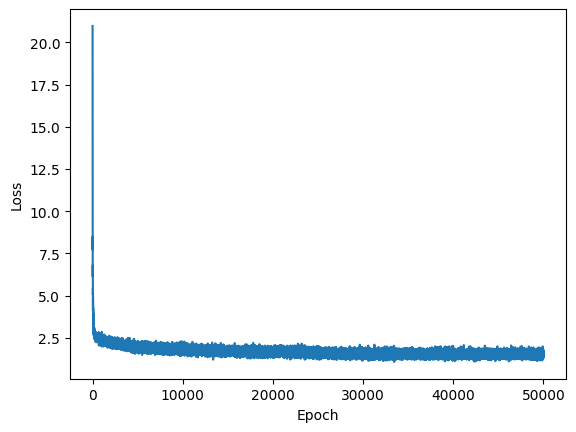

In [54]:
plt.plot(np.arange(len(losses)), losses)
plt.ylabel("Loss")
plt.xlabel("Epoch")

In [55]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtrain, Ytrain),
        'dev': (Xdev, Ydev),
        'test': (Xtest, Ytest)
    }[split]
    emb = embeddings[x]
    emb = emb.view(emb.shape[0], -1)
    out = model.predict(emb)   
    loss = F.cross_entropy(out, y)

    return loss.item()

In [56]:
split_loss('train'), split_loss('dev'), split_loss('test')

(1.4757354259490967, 1.6017286777496338, 1.6243505477905273)

### Improvement!!

### Pre weight init optimization -> (1.7559022903442383, 1.7703694105148315, 1.785829782485962)
### Post weight init optimization -> (1.7148950099945068, 1.729537844657898, 1.7452518939971924)
### Post Batch norm -> (1.77047860622406, 1.7761619091033936, 1.7911485433578491)
### Multiple layers with batch norm -> (1.4757354259490967, 1.6017286777496338, 1.6243505477905273) - > BEST RESULT YET! (slight overfit but ok)


#### Is this proof that batch norm sucks with lesser layers?

In [64]:
def complete_word(model, start_chars, block_size=10):
    context = [3] * (block_size - len(start_chars))
    context.extend([stoi[ch] for ch in start_chars])
    
    res = list(start_chars)
    
    while True:
        emb = embeddings[torch.tensor(context)]
        emb = emb.view(1, -1)
        out = model.predict(emb)
        
        out = F.softmax(out, dim=-1)
        out = torch.multinomial(out, 1).item()
        
        if out == 3:
            break
            
        res.append(itos[out])
        context = context[1:] + [out]
    
    return ''.join(res)

prompts = [
    "dream",
    "star",
    "moon",
    "whisper",
    "ember",
    "mist",
    "azure",
    "shadow",
    "crystal",
    "velvet",
    "river",
    "sunset",
    "autumn",
    "silver",
    "echo"
]

for word in prompts:
    res = complete_word(model, start_chars=word)
    # make sure there is only one space between words
    res = ' '.join([i.strip() for i in res.split()])
    print(res)

dream resty givens teent she lice unching rets usees mnots the open where or over that'd wind which heart poosped you left to have consure the earth now buth sud your from the most worth it unve i have understections shy
starting all a palse behind swall hever still here of meing conityed my love moon
moon out right up skin boing a tells is no last of life fehting at bring uman
whispers glain
ember of cointer we grass by being of the rain resodied them beseal has night
mistakes out diagain beging all
azure sun
shadow to mater true him i am the earth
crystalty uparaying in love
velvether that may is upon a time whute feels
rivering wind
sunset paces the kills all on bed between the reach we unvoles
autumn i lovefused
silver greated off free yet i pae step tiles away screams calls
echore i of in the your black viewh other sooken


/var/folders/np/gp8d_33j4jxd2pd79hf5w03r0000gn/T/ipykernel_24338/1895009486.py:39: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1823.)
  std = x.std(0, keepdim=True)
